In [0]:
# 라이브러리 불러오기
import tensorflow as tf
import numpy as np

In [0]:
# 꽃 데이터 불러오기
from sklearn import datasets
iris = datasets.load_iris()

x_val = iris['data'][:, 0, None]
y_val = iris['data'][:, -1, None]

x_name = iris['feature_names'][0]
y_name = iris['feature_names'][-1]

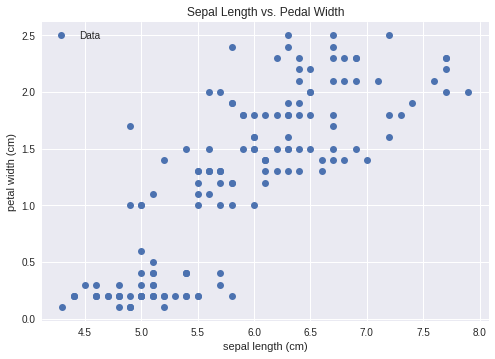

In [3]:
# 데이터 시각화
import matplotlib.pyplot as plt

plt.plot( x_val, y_val, 'o', label='Data' )
plt.legend( loc='upper left' )
plt.title( 'Sepal Length vs. Pedal Width' )
plt.xlabel( x_name )
plt.ylabel(y_name)
plt.show()

In [0]:
# 학습 파라미터 정의

learning_rate = 0.0001
batch_size = 8
epoch = 100

## Tensor 및 Variable 생성

$$
y=weight*x+bias
$$

x 와 y는 feeding이 필요한 tensor

Weight 와  bias는 Variable (또는 가변형 Tensor)

In [0]:
# 입력 Tensor 생성 - Placeholder
x_data = tf.placeholder(shape=(None, 1), dtype=tf.float32)
y_target = tf.placeholder(shape=(None, 1), dtype=tf.float32)

# 변수 (Variable) 생성
with tf.variable_scope("variables", reuse=tf.AUTO_REUSE):
    weight = tf.Variable(initial_value=tf.random_normal(shape=[1, 1]), dtype=tf.float32, name="weight")
    bias = tf.get_variable(initializer=tf.random_normal(shape=[1, 1]), dtype=tf.float32, name="bias")

y_prediction = tf.matmul(x_data, weight)
y_prediction = tf.add(y_prediction, bias)

In [0]:
# 세션 정의
sess = tf.Session()

# Variable 초기화 (weight, bias)
sess.run(tf.global_variables_initializer())

## Loss 및 Optimizer 생성

In [0]:
# Loss / Error 함수 정의 (L2 Loss)
loss = tf.square(y_target - y_prediction)
loss = tf.reduce_mean(loss)

In [0]:
# Optimizer 정의
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
update_operation = optimizer.minimize(loss)

## 학습 시작!

![대체 텍스트](https://github.com/wltjr1007/wltjr1007.github.io/raw/master/KHBM2018_DATA/operation.png)

In [9]:
fetch_dict = {"loss": loss, "update": update_operation} # 출력 및 실행 할 Tensor
feed_dict = {x_data: None, y_target: None} # 입력 할 Tensor

loss_log = []

for current_epoch in range(epoch):
    # 임의의 데이터 선택
    random_index = np.random.permutation(len(x_val))
    for step in range(0, len(random_index), batch_size):
        current_index=random_index[step:step+batch_size]
        feed_dict.update({x_data: x_val[current_index], y_target: y_val[current_index]})
        
        ## fetch_dict의 모든 Tensor들을 실행 및 출력한다
        result = sess.run(fetch_dict, feed_dict=feed_dict)
        
        loss_log += [result["loss"]]
    if current_epoch%10 ==0:
        print(current_epoch, loss_log[-1])

0 1.346183
10 0.8373949
20 0.45845494
30 0.11351595
40 0.5112674
50 0.040798362
60 0.34340182
70 0.4116069
80 0.16903818
90 0.5556683


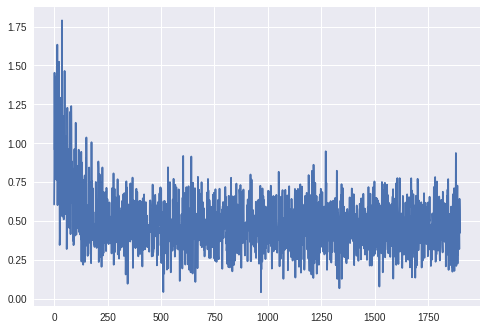

In [10]:
# Loss 그래프 시각화
plt.plot(loss_log)
plt.show()

## Tensorboard 및 모델 저장/불러오기

In [0]:
model_path = "./model/"
summary_path = "./log/"

!rm -rf ./log
!rm -rf ./model

# Tensorboard Summary
summary_writer = tf.summary.FileWriter(summary_path, graph=sess.graph)
summary_op = tf.summary.merge([
    tf.summary.scalar("loss", loss)
])

# Model Saver
saver = tf.train.Saver()

In [12]:
# 모델 다시 초기화
sess.run(tf.global_variables_initializer())

fetch_dict = {"loss": loss, "update": update_operation, "summary": summary_op}
feed_dict = {x_data: None, y_target: None}

trn_cnt = 0
for current_epoch in range(epoch):
    random_index = np.random.permutation(len(x_val))
    for step in range(0, len(random_index), batch_size):
        current_index=random_index[step:step+batch_size]
        feed_dict.update({x_data: x_val[current_index], y_target: y_val[current_index]})
        
        result = sess.run(fetch_dict, feed_dict=feed_dict)
        
        # 각 step 마다 시각화
        summary_writer.add_summary(result["summary"], global_step=trn_cnt)
        
        trn_cnt +=1
    # 각 epoch 마다 모델 저장    
    saver.save(sess=sess, save_path=model_path+"%d.ckpt"%current_epoch)
    if current_epoch % 10 ==0:
        print("Checkpoint saved in %s"%model_path+"%d.ckpt"%current_epoch)

Checkpoint saved in ./model/0.ckpt
Checkpoint saved in ./model/10.ckpt
Checkpoint saved in ./model/20.ckpt
Checkpoint saved in ./model/30.ckpt
Checkpoint saved in ./model/40.ckpt
Checkpoint saved in ./model/50.ckpt
Checkpoint saved in ./model/60.ckpt
Checkpoint saved in ./model/70.ckpt
Checkpoint saved in ./model/80.ckpt
Checkpoint saved in ./model/90.ckpt


In [13]:
def get_loss():
    loss_log = []
    for cnt, (x, y) in enumerate(zip(x_val, y_val)):
        l = sess.run(loss, feed_dict={x_data:x[None], y_target:y[None]})
        loss_log+=[l]
    return np.mean(loss_log)

# 저장된 모델을 불러오기 전과 후의 차이

#전
sess.run(tf.global_variables_initializer())
before_loss = get_loss()

#후
saver.restore(sess=sess, save_path=model_path+"99.ckpt")
after_loss = get_loss()

print("전 Loss: %f"%before_loss)
print("후 Loss: %f"%after_loss)

INFO:tensorflow:Restoring parameters from ./model/99.ckpt
전 Loss: 43.136074
후 Loss: 0.405536


In [14]:
# Tensorboard 데모
!wget -nc https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py

import tboard
ROOT=%pwd
url = tboard.launch_tensorboard(bin_dir=ROOT, log_dir=summary_path)
print(url)

--2018-08-01 08:40:17--  https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘tboard.py’

tboard.py           100%[===================>]   5.09K  --.-KB/s    in 0s      

2018-08-01 08:40:18 (57.0 MB/s) - ‘tboard.py’ saved [5214/5214]

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= http://811d4565.ngrok.io
http://811d4565.ngrok.io
